## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## EDA

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.duplicated().sum()

0

In [5]:
# Check dataset size
print(f"Dataset size: {len(labels)} images")
print(f"Columns: {labels.columns.tolist()}")
print(labels.head())

Dataset size: 7591 images
Columns: ['file_name', 'real_age']
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [6]:
# Age ranges
print(f"Age range: {labels['real_age'].min()} - {labels['real_age'].max()}")
print(f"Most common age: {labels['real_age'].mode()[0]}")

# Check for potential issues
print(f"Missing values: {labels['real_age'].isnull().sum()}")

Age range: 1 - 100
Most common age: 30
Missing values: 0


Age statistics:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


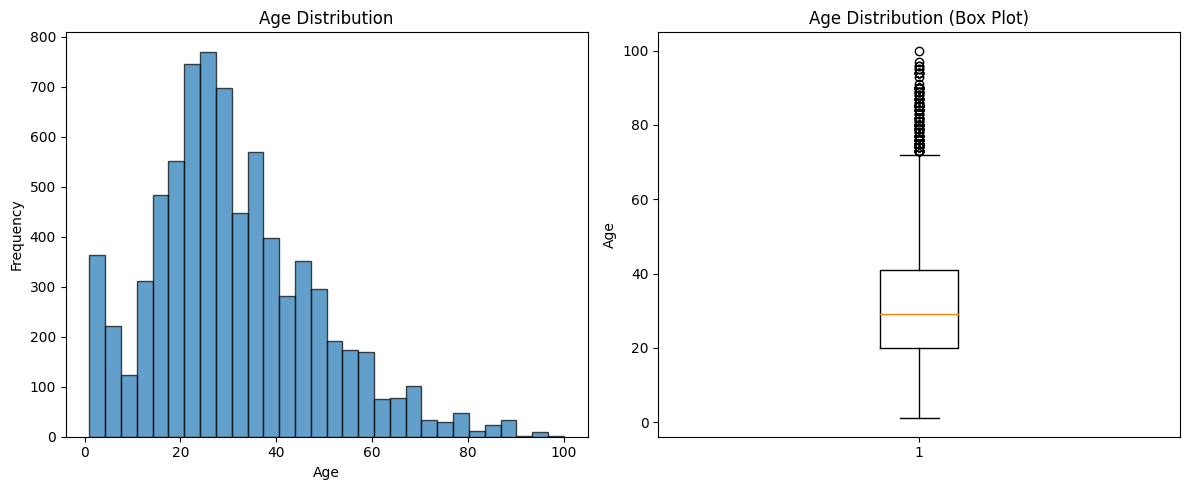

In [7]:
# Basic statistics
print("Age statistics:")
print(labels['real_age'].describe())

# Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(labels['real_age'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(labels['real_age'])
plt.title('Age Distribution (Box Plot)')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

**The graph illustrates the data as being right-skewed with most samples in the range of 20-50. Although there are outliers shown on the box plot, it's my recommendation to keep them since it is a real-world representation. Removing the outliers would also reduce our already limited dataset.**

In [8]:
# Create age ranges and sample from each
age_ranges = [(1, 10), (11, 20), (21, 30), (31, 40), (41, 50), 
              (51, 60), (61, 70), (71, 80), (81, 90), (91, 100)]

sampled_images = []

for min_age, max_age in age_ranges:
    # Filter by age range
    age_group = labels[(labels['real_age'] >= min_age) & 
                       (labels['real_age'] <= max_age)]
    
    if len(age_group) > 0:  # Check if age group exists
        # Sample one image from this age range
        sample = age_group.sample(n=1, random_state=42)
        sampled_images.append(sample.iloc[0])

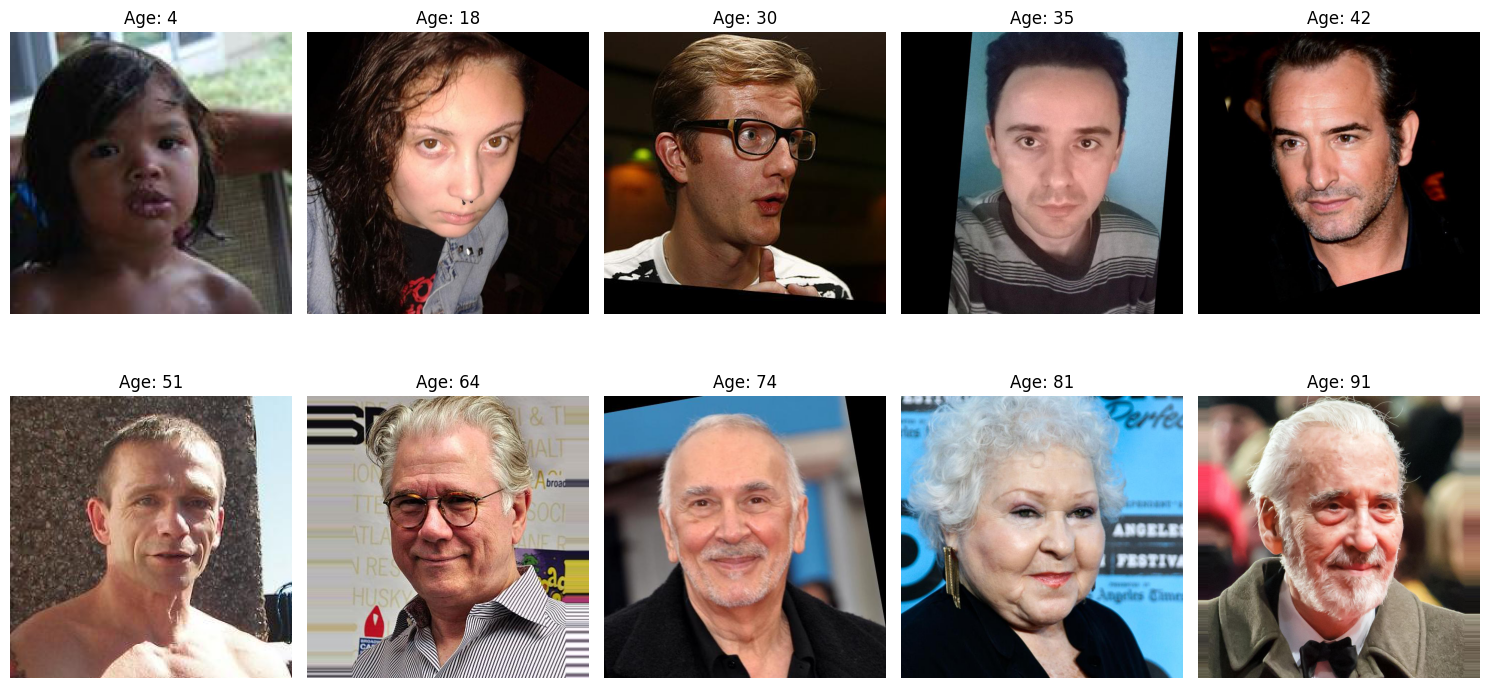

In [9]:
# Create a grid to display images
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i, row in enumerate(sampled_images[:10]):  # Display up to 10 images
    # Load image
    img_path = f"/datasets/faces/final_files/{row['file_name']}"
    img = Image.open(img_path)
    
    # Display image
    axes[i].imshow(img)
    axes[i].set_title(f"Age: {row['real_age']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Findings

**The exploratory data analysis gave us a meaningful insight into the ages provided in the dataset. Representation is limited for very young and elderly individuals, so this could affect the overall model performance. Once we evaluate the model, it may be beneficial to use strategies like data augmentation, weighted loss function, or model performance evaluation across different age ranges.**

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [10]:
def load_train(path):
    
    # Load labels
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    # Create ImageDataGenerator with data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25)
    
    # Create the training data generator
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    return train_gen_flow

In [11]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # Load the labels
    labels = pd.read_csv('/datasets/faces/labels.csv')

    # Create an ImageDataGenerator for testing
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create the testing data generator
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    return test_gen_flow

In [12]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # Load pre-trained ResNet50 without top layers
    backbone = ResNet50(input_shape=input_shape, 
                       weights='imagenet', 
                       include_top=False)
    
    # Create the model
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))  # Single output for age prediction
    
    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001), 
                  loss='mae', 
                  metrics=['mae'])

    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # Train the model
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [14]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training